In [1]:
pip install pandas numpy pulp geopy


   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB 262.6 kB/s eta 0:01:03
   ---------------------------------------- 0.0/16.4 MB 262.6 kB/s eta 0:01:03
   ---------------------------------------- 0.0/16.4 MB 196.9 kB/s eta 0:01:24
   ---------------------------------------- 0.0/16.4 MB 196.9 kB/s eta 0:01:24
   ---------------------------------------- 0.0/16.4 MB 196.9 kB/s eta 0:01:24
   ---------------------------------------- 0.0/16.4 MB 196.9 kB/s eta 0:01:24
   ---------------------------------------- 0.1/16.4 MB 156.1 kB/s eta 0:01:45
   ---------------------------------------- 0.1/16.4 MB 156.1 kB/s eta 0:01:45
   ---------------------------------------- 0.1/16.4 MB 248.7 kB/s eta 0:01:06
   ---------------------------------------- 0.1/16.4 MB 248.7 kB/s eta 0:01:06
   ---------------------------------------- 0.2/16.4 MB 262.6 kB/s eta

In [2]:
import pandas as pd
import numpy as np
import pulp
from geopy.distance import geodesic

In [4]:
df = pd.read_csv(r"C:\Users\kumkum trivedi\Downloads\archive (5)\smart_logistics_dataset.csv")

In [12]:
# Drop rows with missing critical values
df = df.dropna(subset=[
    "Latitude",
    "Longitude",
    "Inventory_Level",
    "Demand_Forecast",
    "Traffic_Status"
])


In [27]:
print(df.columns)


Index(['Timestamp', 'Asset_ID', 'Latitude', 'Longitude', 'Inventory_Level',
       'Shipment_Status', 'Temperature', 'Humidity', 'Traffic_Status',
       'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency',
       'Logistics_Delay_Reason', 'Asset_Utilization', 'Demand_Forecast',
       'Logistics_Delay', 'Traffic_Factor'],
      dtype='object')


In [42]:
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.lower()
)


In [5]:
df = df[df["Shipment_Status"] == "Delivered"]

In [6]:
# Create Plants (Supply)

plants = (
    df.groupby("Asset_ID")
    .agg({
        "Inventory_Level": "mean",
        "Latitude": "first",
        "Longitude": "first"
    })
    .reset_index()
)

plants.rename(columns={"Inventory_Level": "Supply"}, inplace=True)

In [7]:
# Create Distribution Centers (Demand)
dcs = (
    df.groupby(["Latitude", "Longitude"])
    .agg({
        "Demand_Forecast": "mean"
    })
    .reset_index()
)

dcs["DC_ID"] = ["DC_" + str(i+1) for i in range(len(dcs))]
dcs.rename(columns={"Demand_Forecast": "Demand"}, inplace=True)

In [8]:
# Distance Matrix (km)

distance = {}
for _, p in plants.iterrows():
    for _, d in dcs.iterrows():
        distance[(p.Asset_ID, d.DC_ID)] = geodesic(
            (p.Latitude, p.Longitude),
            (d.Latitude, d.Longitude)
        ).km

In [9]:
# Cost Adjustments (Realism)

BASE_PTPK = 2.5

traffic_penalty = {
    "Low": 1.0,
    "Medium": 1.15,
    "High": 1.30
}

avg_traffic_factor = (
    df["Traffic_Status"]
    .map(traffic_penalty)
    .mean()
)

PTPK = BASE_PTPK * avg_traffic_factor

In [10]:
# Optimization Model
# -----------------------------
model = pulp.LpProblem("PTPK_Transport_Optimization", pulp.LpMinimize)

# Decision Variables
x = pulp.LpVariable.dicts(
    "ship_qty",
    [(p.Asset_ID, d.DC_ID) for _, p in plants.iterrows() for _, d in dcs.iterrows()],
    lowBound=0,
    cat="Continuous"
)


In [14]:
df["Inventory_Level"] = pd.to_numeric(df["Inventory_Level"], errors="coerce")
df["Demand_Forecast"] = pd.to_numeric(df["Demand_Forecast"], errors="coerce")

df = df.dropna(subset=["Inventory_Level", "Demand_Forecast"])


In [15]:
traffic_penalty = {
    "Low": 1.0,
    "Medium": 1.15,
    "High": 1.30
}

df["Traffic_Factor"] = df["Traffic_Status"].map(traffic_penalty)

# Replace unknown traffic statuses with neutral factor
df["Traffic_Factor"] = df["Traffic_Factor"].fillna(1.1)

PTPK = 2.5 * df["Traffic_Factor"].mean()


In [16]:
distance = {}

for _, p in plants.iterrows():
    for _, d in dcs.iterrows():
        try:
            dist = geodesic(
                (p.Latitude, p.Longitude),
                (d.Latitude, d.Longitude)
            ).km

            if np.isfinite(dist):
                distance[(p.Asset_ID, d.DC_ID)] = dist
            else:
                distance[(p.Asset_ID, d.DC_ID)] = 9999  # heavy penalty

        except:
            distance[(p.Asset_ID, d.DC_ID)] = 9999


In [17]:
assert not np.isnan(PTPK), "PTPK is NaN"

for k, v in distance.items():
    assert np.isfinite(v), f"Invalid distance for {k}"


In [18]:
model += pulp.lpSum(
    x[(p.Asset_ID, d.DC_ID)] * distance[(p.Asset_ID, d.DC_ID)] * PTPK
    for _, p in plants.iterrows()
    for _, d in dcs.iterrows()
)


In [19]:
x = pulp.LpVariable.dicts(
    "ship_qty",
    [(p.Asset_ID, d.DC_ID) for _, p in plants.iterrows() for _, d in dcs.iterrows()],
    lowBound=0,
    upBound=5000,
    cat="Continuous"
)


In [22]:

# Supply Constraints
for _, p in plants.iterrows():
    model += (
        pulp.lpSum(x[(p.Asset_ID, d.DC_ID)] for _, d in dcs.iterrows())
        <= p.Supply
    )

# Demand Constraints
for _, d in dcs.iterrows():
    model += (
        pulp.lpSum(x[(p.Asset_ID, d.DC_ID)] for _, p in plants.iterrows())
        >= d.Demand
    )

In [23]:
# Solve

model.solve()

print("Status:", pulp.LpStatus[model.status])
print("Total Transport Cost:", pulp.value(model.objective))

Status: Infeasible
Total Transport Cost: 82908984.58232781


In [24]:
# Results
results = []
for _, p in plants.iterrows():
    for _, d in dcs.iterrows():
        qty = x[(p.Asset_ID, d.DC_ID)].value()
        if qty and qty > 0:
            results.append([
                p.Asset_ID,
                d.DC_ID,
                round(qty, 2),
                round(distance[(p.Asset_ID, d.DC_ID)], 2),
                round(qty * distance[(p.Asset_ID, d.DC_ID)] * PTPK, 2)
            ])

result_df = pd.DataFrame(
    results,
    columns=["Plant", "DC", "Quantity", "Distance_km", "Cost"]
)

result_df.to_csv("optimized_routes.csv", index=False)
print(result_df)

       Plant      DC  Quantity  Distance_km         Cost
0    Truck_1  DC_133    269.66      3056.40   2266488.95
1   Truck_10   DC_17    589.97      6405.11  10391775.08
2    Truck_2   DC_40    285.20      5650.61   4431774.10
3    Truck_2   DC_58     14.15      5688.07    221337.11
4    Truck_2   DC_67    300.00      5569.54   4594868.56
5    Truck_2   DC_87    292.00      5897.56   4735744.36
6    Truck_2  DC_133     20.34      7312.71    409111.75
7    Truck_3  DC_109    285.97      5897.03   4637541.64
8    Truck_3  DC_157    285.97      3610.94   2839715.30
9    Truck_4  DC_109    294.47     11469.81   9288207.52
10   Truck_4  DC_183    294.47      5700.62   4616344.52
11   Truck_4  DC_217   1711.33      9877.23  46483806.63
12   Truck_4  DC_332    294.47      4235.84   3430171.74
13   Truck_5  DC_223   1166.89      3439.00  11035606.10
14   Truck_5  DC_247    296.00      5614.70   4570365.18
15   Truck_5  DC_314    296.00      2597.64   2114475.79
16   Truck_6   DC_40      4.80 

In [ ]:
#visuals


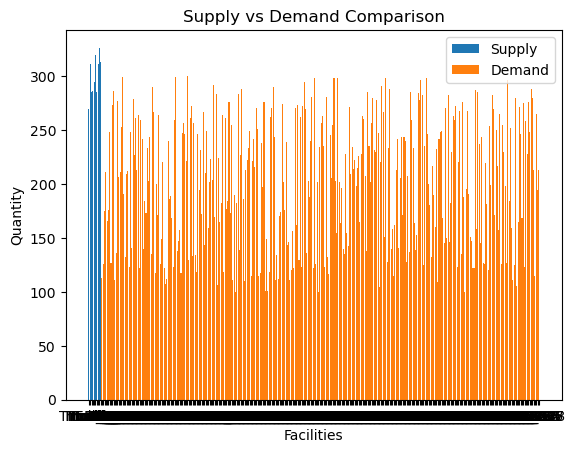

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(plants['Asset_ID'], plants['Supply'], label='Supply')
plt.bar(dcs['DC_ID'], dcs['Demand'], label='Demand')
plt.xlabel("Facilities")
plt.ylabel("Quantity")
plt.title("Supply vs Demand Comparison")
plt.legend()
plt.show()


In [31]:
print(df.columns.tolist())


['Timestamp', 'Asset_ID', 'Latitude', 'Longitude', 'Inventory_Level', 'Shipment_Status', 'Temperature', 'Humidity', 'Traffic_Status', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Logistics_Delay_Reason', 'Asset_Utilization', 'Demand_Forecast', 'Logistics_Delay', 'Traffic_Factor']


In [33]:
from geopy.distance import geodesic


In [34]:
# Example: use central hub / DC coordinates
dc_lat = df["Latitude"].mean()
dc_lon = df["Longitude"].mean()

df["Distance_km"] = df.apply(
    lambda row: geodesic(
        (row["Latitude"], row["Longitude"]),
        (dc_lat, dc_lon)
    ).km,
    axis=1
)


In [36]:
base_rate = 2.5  # ₹ per tonne per km

traffic_map = {
    "Low": 1.0,
    "Medium": 1.15,
    "High": 1.30
}

df["Traffic_Factor"] = df["Traffic_Status"].map(traffic_map)
df["Traffic_Factor"] = df["Traffic_Factor"].fillna(1.1)

df["Rate"] = base_rate * df["Traffic_Factor"]


In [43]:
print(df.columns)


Index(['timestamp', 'asset_id', 'latitude', 'longitude', 'inventory_level',
       'shipment_status', 'temperature', 'humidity', 'traffic_status',
       'waiting_time', 'user_transaction_amount', 'user_purchase_frequency',
       'logistics_delay_reason', 'asset_utilization', 'demand_forecast',
       'logistics_delay', 'traffic_factor', 'distance_km', 'rate',
       'transport_cost'],
      dtype='object')


In [45]:
for col in df.columns:
    print(repr(col))


'timestamp'
'asset_id'
'latitude'
'longitude'
'inventory_level'
'shipment_status'
'temperature'
'humidity'
'traffic_status'
'waiting_time'
'user_transaction_amount'
'user_purchase_frequency'
'logistics_delay_reason'
'asset_utilization'
'demand_forecast'
'logistics_delay'
'traffic_factor'
'distance_km'
'rate'
'transport_cost'


In [46]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)


In [47]:
print(df.columns)


Index(['timestamp', 'asset_id', 'latitude', 'longitude', 'inventory_level',
       'shipment_status', 'temperature', 'humidity', 'traffic_status',
       'waiting_time', 'user_transaction_amount', 'user_purchase_frequency',
       'logistics_delay_reason', 'asset_utilization', 'demand_forecast',
       'logistics_delay', 'traffic_factor', 'distance_km', 'rate',
       'transport_cost'],
      dtype='object')


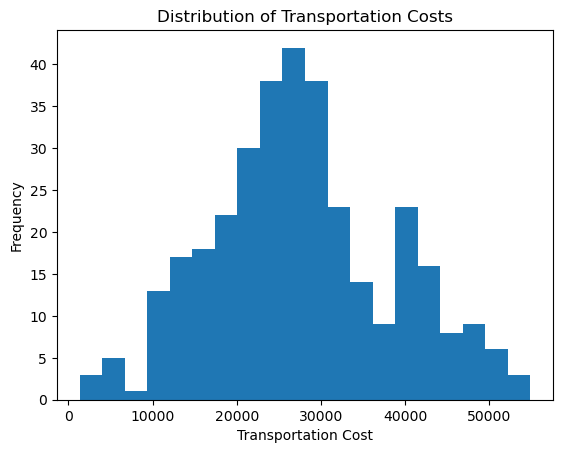

In [48]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['transport_cost'], bins=20)
plt.xlabel("Transportation Cost")
plt.ylabel("Frequency")
plt.title("Distribution of Transportation Costs")
plt.show()


In [50]:
    print(results[0])
len(results[0])


['Truck_1', 'DC_133', 269.66, 3056.4, 2266488.95]


5

In [51]:
results_df = pd.DataFrame(
    results,
    columns=["Plant_ID", "DC_ID", "Quantity", "Cost_per_unit", "Total_Cost"]
)


In [52]:
results_df = pd.DataFrame(results).iloc[:, :4]
results_df.columns = ["Plant_ID", "DC_ID", "Quantity", "Cost"]


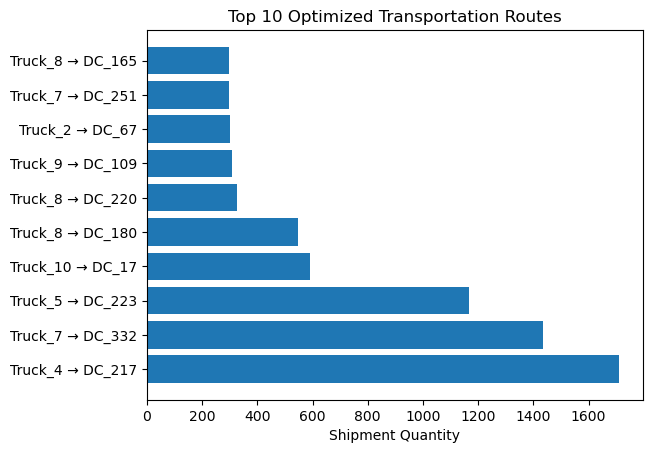

In [53]:
top_routes = results_df.sort_values("Quantity", ascending=False).head(10)

plt.figure()
plt.barh(
    top_routes["Plant_ID"].astype(str) + " → " + top_routes["DC_ID"].astype(str),
    top_routes["Quantity"]
)
plt.xlabel("Shipment Quantity")
plt.title("Top 10 Optimized Transportation Routes")
plt.show()
